**Unsupervised clustering**

Also using:

https://github.com/CONABIO/antares3/blob/rapideye-support/madmex/overlay/conversions.py#L8


# First approach ... but this didn't go well...

In [1]:
import json
from sklearn.cluster import KMeans
from affine import Affine
import numpy as np

import fiona
from fiona.crs import to_string
from datacube.utils.geometry import CRS
from rasterio.features import rasterize
from rasterio import features


In [2]:
def polygonize(array_gen, affine_values):
    """Transform the raster result of a segmentation to a feature collection
    Return:
        list: The feature collection resulting from the segmentation
    """
    # Use rasterio.features.shapes to generate a geometries collection from the
    # segmented raster
    geom_collection = features.shapes(array_gen.astype(rasterio.int32),
                                      transform=affine_values)
    # Make it a valid featurecollection
    def to_feature(feature):
        """Tranforms the results of rasterio.feature.shape to a feature"""
        fc_out = {
            "type": "Feature",
            "geometry": mapping(shape(feature[0]).buffer(0)),
            "properties": {
                "id": feature[1]
            }
        }
        # The zero buffering should avoid invalid geometries generated by rasterio.shape
        geos_geom_buffer = GEOSGeometry(json.dumps(fc_out['geometry'])).buffer(0)
        fc_out['geometry'] = json.loads(geos_geom_buffer.geojson)
        return fc_out
    return [to_feature(x) for x in geom_collection]

In [3]:
def to_shapefile(filename, crs_v, fc=None):
    """Write the result of the segmentation to a ESRI Shapefile file
    Args:
        filename (str): File name (use full path when writing to filesystem)
            and basename when writing to s3 bucket
        fc (dict): Feature collection with one property who's name must be
            id. Typically the return of the ``polygonize()`` method.
            Can be ``None``, in which case, it is generated on the fly
        bucket (string): Optional name of s3 bucket to write the shapefile
    Return:
        str: The function is used for its side effect of writing a feature
        collection to file, however, it also returns the path to the written file
    """
    crs = from_string(crs_v)
    schema = {'geometry': 'Polygon',
              'properties': {'id': 'int'}}
    with fiona.open(filename, 'w',
                    driver='ESRI Shapefile',
                    schema=schema,
                    crs=crs) as dst:
        for feature in fc:
            dst.write(feature)

    return filename

In [4]:
l_affine = [10.0, 0.0, 2927940.0, 0.0, -10.0, 976140.0]

In [5]:
l_affine

[10.0, 0.0, 2927940.0, 0.0, -10.0, 976140.0]

In [6]:
crs_attr = 'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]]'

In [7]:
crs_attr

'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS84",6378137,6556752.3141]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0]]'

In [8]:
affine_values = Affine(*l_affine)
crs_value = CRS(crs_attr)

In [2]:
shp_path = '/shared_volume/temp/segmentation_results/fft_max_28_11_2019_sentinel2_bis_t_40_s_0.5_c_0.7.shp'
shp_path = '/LUSTRE/MADMEX/tasks/2019_tasks/generacion_datos_entrenamiento_cultivos/examples_segmentation_results/slic_seg_s2_10m_Veracruz_sample_2019_sentinel_2_39_-30_2019.shp'

In [11]:
with fiona.open(shp_path, driver='ESRI Shapefile') as src:
    crs_value_2 = to_string(src.crs)
    fc = [(x['properties']['id'], x['geometry']) for x in src]
    

In [12]:
crs_value_2

'+a=6378137 +b=6378136.027241431 +lat_0=12 +lat_1=17.5 +lat_2=29.5 +lon_0=-102 +no_defs +proj=lcc +units=m +x_0=2500000 +y_0=0'

In [13]:
fc[0]

(0,
 {'type': 'Polygon',
  'coordinates': [[(2927940.0, 976140.0),
    (2928850.0, 976140.0),
    (2928850.0, 975230.0),
    (2927940.0, 975230.0),
    (2927940.0, 976140.0)]]})

In [18]:
fc[0][1]

{'type': 'Polygon',
 'coordinates': [[(2927940.0, 976140.0),
   (2928850.0, 976140.0),
   (2928850.0, 975230.0),
   (2927940.0, 975230.0),
   (2927940.0, 976140.0)]]}

In [25]:
geom_list = [x[1] for x in fc]

In [27]:
geom_list[0]

{'type': 'Polygon',
 'coordinates': [[(2927940.0, 976140.0),
   (2928850.0, 976140.0),
   (2928850.0, 975230.0),
   (2927940.0, 975230.0),
   (2927940.0, 976140.0)]]}

In [28]:
iterable = zip(geom_list, range(1, len(geom_list) + 1))

In [29]:
aff = Affine(*l_affine)

In [30]:
fc_raster = rasterize(iterable, transform=aff,
                      out_shape=(5002, 5002),
                      dtype='float64', fill=np.nan)

In [31]:
fc_raster

array([[1.000e+00, 1.000e+00, 1.000e+00, ..., 5.500e+01, 5.500e+01,
        5.500e+01],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 5.500e+01, 5.500e+01,
        5.500e+01],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 5.500e+01, 5.500e+01,
        5.500e+01],
       ...,
       [2.971e+03, 2.971e+03, 2.971e+03, ..., 3.025e+03, 3.025e+03,
        3.025e+03],
       [2.971e+03, 2.971e+03, 2.971e+03, ..., 3.025e+03, 3.025e+03,
        3.025e+03],
       [2.971e+03, 2.971e+03, 2.971e+03, ..., 3.025e+03, 3.025e+03,
        3.025e+03]])

In [39]:
fc_raster.shape

(5002, 5002)

In [33]:
from numpy.random import RandomState

In [40]:
kmeans = KMeans(n_clusters=10, random_state=RandomState(1898))

In [41]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=RandomState(MT19937) at 0x7FC7E8BC5360, tol=0.0001,
       verbose=0)

In [42]:
kmeans.fit(fc_raster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=RandomState(MT19937) at 0x7FC7E8BC5360, tol=0.0001,
       verbose=0)

In [43]:
kmeans.cluster_centers_

array([[1596.        , 1596.        , 1596.        , ..., 1650.        ,
        1650.        , 1650.        ],
       [ 441.        ,  441.        ,  441.        , ...,  495.        ,
         495.        ,  495.        ],
       [2832.84162063, 2832.84162063, 2832.84162063, ..., 2886.84162063,
        2886.84162063, 2886.84162063],
       ...,
       [1321.        , 1321.        , 1321.        , ..., 1375.        ,
        1375.        , 1375.        ],
       [1898.5       , 1898.5       , 1898.5       , ..., 1952.5       ,
        1952.5       , 1952.5       ],
       [ 716.        ,  716.        ,  716.        , ...,  770.        ,
         770.        ,  770.        ]])

In [53]:
kmeans.cluster_centers_.shape

(10, 5002)

In [44]:
kmeans.labels_

array([5, 5, 5, ..., 2, 2, 2], dtype=int32)

In [45]:
kmeans.labels_.shape

(5002,)

In [49]:
labels = kmeans.fit_predict(fc_raster)

In [50]:
labels

array([6, 6, 6, ..., 0, 0, 0], dtype=int32)

In [51]:
labels.shape

(5002,)

# Other approach

In [1]:
shp_path = '/shared_volume/temp/segmentation_results/fft_max_28_11_2019_sentinel2_bis_t_40_s_0.5_c_0.7.shp'
shp_path = '/LUSTRE/MADMEX/tasks/2019_tasks/generacion_datos_entrenamiento_cultivos/examples_segmentation_results/slic_seg_s2_10m_Veracruz_sample_2019_sentinel_2_39_-30_2019.shp'

In [23]:
import geopandas as gpd
from sklearn.cluster import KMeans


In [3]:
segments = gpd.read_file(shp_path)

In [4]:
segments.head()

,id,geometry
0,0,"POLYGON ((2927940 976140, 2928850 976140, 2928..."
1,1,"POLYGON ((2928850 976140, 2929760 976140, 2929..."
2,2,"POLYGON ((2929760 976140, 2930670 976140, 2930..."
3,3,"POLYGON ((2930670 976140, 2931580 976140, 2931..."
4,4,"POLYGON ((2931580 976140, 2932490 976140, 2932..."


Getting centroids

In [5]:
points = segments.copy()

In [6]:
points.head()

,id,geometry
0,0,"POLYGON ((2927940 976140, 2928850 976140, 2928..."
1,1,"POLYGON ((2928850 976140, 2929760 976140, 2929..."
2,2,"POLYGON ((2929760 976140, 2930670 976140, 2930..."
3,3,"POLYGON ((2930670 976140, 2931580 976140, 2931..."
4,4,"POLYGON ((2931580 976140, 2932490 976140, 2932..."


In [7]:
points.geometry = points['geometry'].centroid

In [8]:
segments.crs

{'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'a': 6378137,
 'b': 6378136.027241431,
 'units': 'm',
 'no_defs': True}

In [9]:
points.crs =segments.crs

In [10]:
points.head()

,id,geometry
0,0,POINT (2928395 975685)
1,1,POINT (2929305 975685)
2,2,POINT (2930215 975685)
3,3,POINT (2931125 975685)
4,4,POINT (2932035 975685)


In [11]:
def getXY(pt):
    return (pt.x, pt.y)
x,y = [list(t) for t in zip(*map(getXY, points.geometry))]

In [12]:
points['y'] = y

In [13]:
points.head()

,id,geometry,y
0,0,POINT (2928395 975685),975685.0
1,1,POINT (2929305 975685),975685.0
2,2,POINT (2930215 975685),975685.0
3,3,POINT (2931125 975685),975685.0
4,4,POINT (2932035 975685),975685.0


In [14]:
points['x']=x

In [15]:
points.head()

,id,geometry,y,x
0,0,POINT (2928395 975685),975685.0,2928395.0
1,1,POINT (2929305 975685),975685.0,2929305.0
2,2,POINT (2930215 975685),975685.0,2930215.0
3,3,POINT (2931125 975685),975685.0,2931125.0
4,4,POINT (2932035 975685),975685.0,2932035.0


In [16]:
name_file = '/LUSTRE/MADMEX/tasks/2019_tasks/generacion_datos_entrenamiento_cultivos/examples_segmentation_results/slic_seg_s2_10m_Veracruz_sample_2019_sentinel_2_39_-30_2019_centroids.shp'

In [17]:
points.to_file(name_file)

In [18]:
train = points.sample(frac=0.7, random_state=14)
test = points.drop(train.index)


In [19]:
train.shape, test.shape

((2118, 4), (907, 4))

In [20]:
train_coords = train[['y', 'x']].values
test_coords = test[['y', 'x']].values

In [24]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(train_coords)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
preds = kmeans.predict(test_coords)

# Get centers of the clusters
centers = kmeans.cluster_centers_

In [26]:
preds

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 6, 6, 9, 9, 9, 9, 9, 5,
       5, 5, 5, 6, 6, 6, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 9, 9, 5, 5, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 6, 6, 9, 9, 9,
       9, 5, 5, 5, 5, 6, 6, 6, 6, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 9, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 9, 9, 9, 9, 9, 9, 5, 5, 5, 5, 6, 6, 6, 6, 9, 9, 9, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 5, 5,
       5, 5, 6, 6, 6, 6, 6, 6, 9, 9, 8, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 9, 9,
       9, 9, 9, 9, 8, 8, 8, 8, 8, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 9, 9, 9,
       8, 8, 8, 8, 5, 5, 5, 2, 2, 2, 6, 6, 6, 6, 0,

In [27]:
preds.shape

(907,)

In [28]:
centers

array([[ 950090.05263158, 2934573.42105263],
       [ 935202.66806723, 2951699.41176471],
       [ 950908.60824742, 2959564.84536082],
       [ 933724.60280374, 2936334.11214953],
       [ 949024.45945946, 2972289.48648649],
       [ 969084.10447761, 2953924.80099502],
       [ 967289.76595745, 2970474.21276596],
       [ 933476.12970711, 2968883.15899582],
       [ 955140.18518519, 2945959.44444444],
       [ 968412.8111588 , 2936401.43776824]])

In [29]:
centers.shape

(10, 2)

In [30]:
import matplotlib.pyplot as plt 

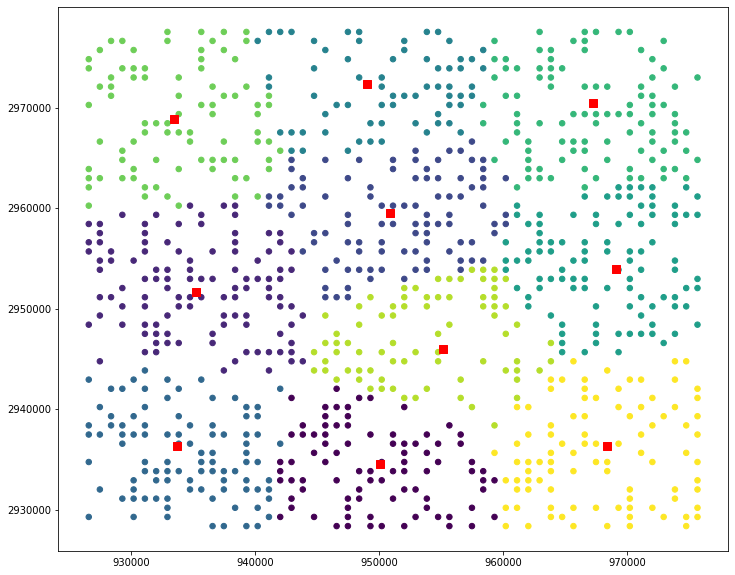

In [31]:
fig, ax = plt.subplots(figsize=(12,10))
plt.scatter(test_coords[:, 0], test_coords[:, 1], c=preds, s=30, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='Red', marker="s", s=50);

## Using no split into train and test

In [32]:
points_coords = points[['y', 'x']].values

In [33]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(points_coords)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [34]:
preds = kmeans.predict(points_coords)

# Get centers of the clusters
centers = kmeans.cluster_centers_

In [35]:
preds

array([2, 2, 2, ..., 9, 9, 9], dtype=int32)

In [36]:
preds.shape

(3025,)

In [37]:
centers

array([[ 934374.60244648, 2936072.95107034],
       [ 967819.60365854, 2952468.38414634],
       [ 968013.78504673, 2936236.30841121],
       [ 934073.11746988, 2953003.37349398],
       [ 951330.42857143, 2972299.44897959],
       [ 951586.18577075, 2933887.3715415 ],
       [ 968051.2611276 , 2969311.33531157],
       [ 950442.39130435, 2946505.97826087],
       [ 951157.40143369, 2959794.89247312],
       [ 934369.03669725, 2969786.16207951]])

In [38]:
centers.shape

(10, 2)

In [39]:
import matplotlib.pyplot as plt 

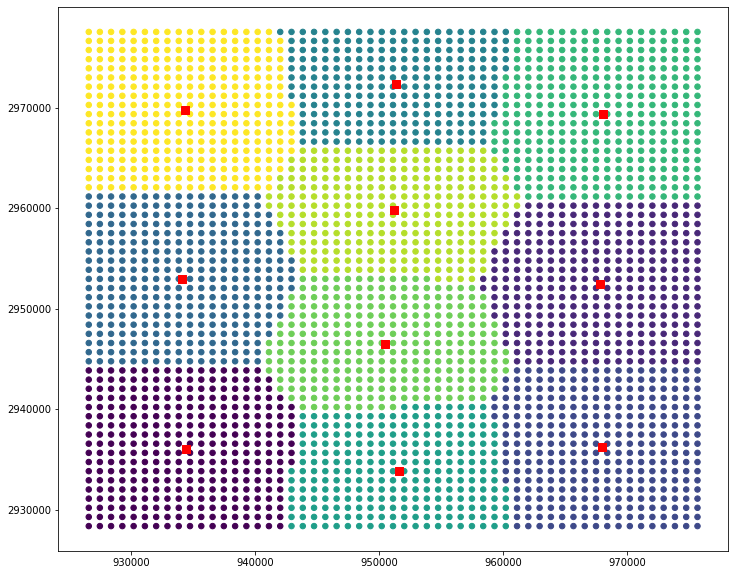

In [40]:
fig, ax = plt.subplots(figsize=(12,10))
plt.scatter(points_coords[:, 0], points_coords[:, 1], c=preds, s=30, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='Red', marker="s", s=50);

Install in container:

```
sudo apt-get update && sudo apt-get install -y libspatialindex-dev
pip3.6 install --user rtree
```

In [45]:
points.head()

,id,geometry,y,x
0,0,POINT (2928395 975685),975685.0,2928395.0
1,1,POINT (2929305 975685),975685.0,2929305.0
2,2,POINT (2930215 975685),975685.0,2930215.0
3,3,POINT (2931125 975685),975685.0,2931125.0
4,4,POINT (2932035 975685),975685.0,2932035.0


In [46]:
points['preds'] = preds

In [47]:
points.head()

,id,geometry,y,x,preds
0,0,POINT (2928395 975685),975685.0,2928395.0,2
1,1,POINT (2929305 975685),975685.0,2929305.0,2
2,2,POINT (2930215 975685),975685.0,2930215.0,2
3,3,POINT (2931125 975685),975685.0,2931125.0,2
4,4,POINT (2932035 975685),975685.0,2932035.0,2


In [62]:
points.id.count()

3025

In [48]:
segments_and_centroids = gpd.sjoin(segments, points, op='contains' )


In [68]:
segments_and_centroids.head()

,id_left,geometry,index_right,id_right,y,x,preds
0,0,"POLYGON ((2927940 976140, 2928850 976140, 2928...",0,0,975685.0,2928395.0,2
1,1,"POLYGON ((2928850 976140, 2929760 976140, 2929...",1,1,975685.0,2929305.0,2
2,2,"POLYGON ((2929760 976140, 2930670 976140, 2930...",2,2,975685.0,2930215.0,2
3,3,"POLYGON ((2930670 976140, 2931580 976140, 2931...",3,3,975685.0,2931125.0,2
4,4,"POLYGON ((2931580 976140, 2932490 976140, 2932...",4,4,975685.0,2932035.0,2


In [63]:
segments_and_centroids.id_left.count()

3025

In [64]:
segments.id.count()

3025

In [52]:
grouped_segments_and_centroids = segments_and_centroids.groupby('preds').size()


In [53]:
grouped_segments_and_centroids

preds
0    327
1    328
2    321
3    332
4    245
5    253
6    337
7    276
8    279
9    327
dtype: int64

In [65]:
name_file = '/LUSTRE/MADMEX/tasks/2019_tasks/generacion_datos_entrenamiento_cultivos/examples_segmentation_results/slic_seg_s2_10m_Veracruz_sample_2019_sentinel_2_39_-30_2019_clustering_result.shp'

In [69]:
segments_and_centroids.drop(['id_left','index_right','id_right','y','x'], axis=1, inplace=True)

In [70]:
segments_and_centroids.head()

,geometry,preds
0,"POLYGON ((2927940 976140, 2928850 976140, 2928...",2
1,"POLYGON ((2928850 976140, 2929760 976140, 2929...",2
2,"POLYGON ((2929760 976140, 2930670 976140, 2930...",2
3,"POLYGON ((2930670 976140, 2931580 976140, 2931...",2
4,"POLYGON ((2931580 976140, 2932490 976140, 2932...",2


**Geopackage**

**Note: Check projection because wasn't correct**

In [71]:
segments_and_centroids.to_file(name_file)

In [76]:
name_file = '/home/madmex_user/slic_seg_s2_10m_Veracruz_sample_2019_sentinel_2_39_-30_2019_clustering_result.gpkg'

**The result moved to: /LUSTRE/MADMEX/tasks/2019_tasks/generacion_datos_entrenamiento_cultivos/examples_segmentation_results/**

In [78]:
segments_and_centroids.to_file(name_file, layer='test', driver="GPKG")
